In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow.keras.utils as ku
import tensorflow as tf
import tensorflow_cloud as tfc
import numpy as np
import glob
import random
import os
from google.cloud import storage

In [6]:
# basedir = '/Users/armandrego/Documents/Python/JREBot/'
# credentials_json = basedir + 'Speech2Text/creds.json'
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credentials_json

# storage_client = storage.Client()

# bucket_list = list(storage_client.list_buckets())
# bucket_name = bucket_list[0].name



In [7]:
# tfc.run(distribution_strategy='auto',
#        docker_image_bucket_name=bucket_name,
#         stream_logs=True)

No labels provided for the training job.Please consider creating labels to help with retrieval of job information. Please see https://cloud.google.com/ai-platform/training/docs/resource-labels for more information.


AttributeError: 'NoneType' object has no attribute 'blocking_request'

In [ ]:
tokenizer = Tokenizer()
data = open('corpus.txt').read()

corpus = data.lower().split('\n ')
tokenizer.fit_on_texts(corpus)
num_of_unique_words = len(tokenizer.word_index) + 1
print('Number of unique words: '+ str(num_of_unique_words))

Number of unique words: 11408


In [ ]:
n = 6
input_texts = []
for i in range(len(corpus)):
    sentence_list = corpus[i].rstrip(' ').split(' ')
    if len(sentence_list) > n:
        startpoint = len(sentence_list)-(n-1)
        endpoint = n-3
    else:
        startpoint = 1
        endpoint = len(sentence_list)-1
            
    for j in range(startpoint):
        for k in range(endpoint):
            line = sentence_list[j+k:j+n]
            input_texts.append(line)
#print(input_texts[:20])
random.shuffle(input_texts)
print('Number of samples: '+str(len(input_texts)))

Number of samples: 615540


In [ ]:
input_sequences = tokenizer.texts_to_sequences(input_texts)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=n, padding='pre'))

predictors = input_sequences[:,:-1]
labels = input_sequences[:,-1]

In [ ]:
class mycallback(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs.get('accuracy') > 0.8:
            print('Stopping early')
            self.model.stop_training = True
            
callback1 = mycallback()

callback2 = EarlyStopping(monitor='accuracy', min_delta = 0.002)

In [ ]:
model = Sequential([
    Embedding(num_of_unique_words, 100, input_length=n-1),
    Bidirectional(LSTM(1024, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(512),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_of_unique_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(num_of_unique_words, activation='softmax')
])
adam = Adam(learning_rate=0.001, decay=1e-5)
sgd = SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 100)            1140800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5, 2048)           9216000   
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 2048)           8192      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 2048)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               5244928   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [ ]:
history = model.fit(predictors,labels, epochs=150, callbacks=[callback1, callback2], 
                    batch_size=200, validation_split=0.15)

Epoch 1/150
2617/2617 [==============================] - 443s 169ms/step - loss: 5.6915 - accuracy: 0.1265 - val_loss: 5.2414 - val_accuracy: 0.1502
Epoch 2/150
2617/2617 [==============================] - 439s 168ms/step - loss: 5.0550 - accuracy: 0.1581 - val_loss: 4.9959 - val_accuracy: 0.1648
Epoch 3/150
2617/2617 [==============================] - 442s 169ms/step - loss: 4.7786 - accuracy: 0.1782 - val_loss: 4.7969 - val_accuracy: 0.1812
Epoch 4/150
2617/2617 [==============================] - 442s 169ms/step - loss: 4.5570 - accuracy: 0.1972 - val_loss: 4.6146 - val_accuracy: 0.2007
Epoch 5/150
2617/2617 [==============================] - 442s 169ms/step - loss: 4.3541 - accuracy: 0.2165 - val_loss: 4.4831 - val_accuracy: 0.2134
Epoch 6/150
2617/2617 [==============================] - 442s 169ms/step - loss: 4.1767 - accuracy: 0.2358 - val_loss: 4.3375 - val_accuracy: 0.2305
Epoch 7/150
2617/2617 [==============================] - 442s 169ms/step - loss: 4.0179 - accuracy: 0.2546

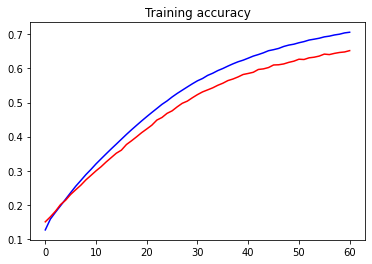

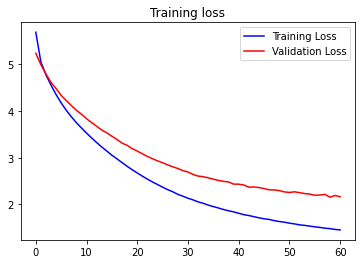

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [30]:
model.save('tmp/jrebot', overwrite=True)

INFO:tensorflow:Assets written to: tmp/jrebot/assets


In [36]:
seed = "the world is going"

next_words = 50
phrase = []
def randomize_word(sequence, temperature=1):
    probs = model.predict(sequence)
    rescaled_logits = tf.math.log(probs)/temperature
    word_id = tf.random.categorical(rescaled_logits, num_samples=1)

    return word_id


for _ in range(next_words):
    phrase = seed.split(' ')[-(n-1)::]
    sequence = tokenizer.texts_to_sequences([phrase])
    sequence = pad_sequences(sequence, maxlen=n-1, padding='pre')
    #predicted = model.predict_classes(sequence)
    predicted = randomize_word(sequence,temperature=0.5)
    next_word = ''
    for word,index in tokenizer.word_index.items():
        if index == predicted[0]:
            next_word = word
            break
    seed += ' ' + next_word

print(seed)
    

the world is going to be in pain all the time cuz you mentioned a lot of people that are going to oppose it and come up with a simulation it's going to be able to detect at the testosterone side of your body is thinking you could be and they can find consensus
